# [Elo7.dev](elo7.dev) Workshops - GAN School 1

- Implementação do Non-Saturating GAN no dataset MNIST

## Bibliotecas que serão usadas

In [1]:
# Manipulação, transformação e gráficos
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct

# pytorch
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

# Manipulação, transformação e gráficos do pytorch
import torch.utils.data as Data
from torchvision import datasets
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

# Define uma semente fixa para a geração de números aleatórios do pytorch
torch.manual_seed(42)

### Define o dispositivo que será usado para processar os cálculos

Ao utilizar os tensores do pytorch podemos usar uma GPU caso ela esteja disponível. A célula abaixo define o device igual a `cuda` caso uma GPU esteja disponível ou igual a `cpu` caso contrário. Com isso, ao definir um tensor X, por exemplo:
```python
X = torch.Tensor(data)
```
podemos simplesmente usar
```python
X = X.to(device)
```
e o pytorch saberá qual dispositivo deve usar.

*Obs:* Se um tensor estiver alocado na GPU e quisermos, por exemplo, transformá-lo em um numpy array devemos passar o mesmo tensor para a CPU:
```python
type(X)
>>> torch.Tensor
X_numpy = X.cpu().data.numpy()
type(X_numpy)
>>> numpy.ndarray
```

In [2]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Obtendo os dados

Vamos baixar o MNIST direto dos datasets do pytorch.

In [4]:
datasets.MNIST('./data', train=True, download=True)
file_images = './data/MNIST/train-images.idx3-ubyte'
file_labels = './data/MNIST/train-labels.idx1-ubyte'

A célula abaixo lê os dados no formato `idx-ubyte` e os transforma em numpy arrays.

In [6]:
with open(file_images,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data_raw = data_raw.reshape((size, nrows, ncols))

data_raw.shape

(60000, 28, 28)

Temos 60000 observações em uma formato de matriz. Verificamos que o valor de cada elemento da matriz representa um pixel da imagem.

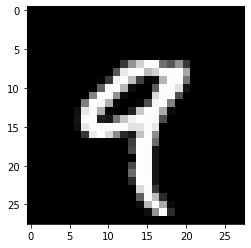

In [7]:
plt.imshow(data_raw[4,:,:], cmap='gray')
plt.show()

Neste módulo do GAN School não vamos utilizar convolução, portanto vamos transformar nosso dataset matricial em flat.

<img src="images/flatten_image.png"
     alt="images/flatten_image"
     style="float: left; margin-right: 3px; width: 200;" />
     
     <img src="images/AI_ven_diagram.png" alt="AI Ven Diagram" style="width: 400px;"/>
<center><font size="1">Fonte: https://blog.algorithmia.com/page/32/</font></center>

In [8]:
data = data_raw.reshape(data_raw.shape[0],data_raw.shape[1]*data_raw.shape[2])
data.shape

(60000, 784)

Fazemos o mesmo procedimento para obter as labels das imagens.

In [9]:
with open(file_labels,'rb') as f:
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

labels = labels[8:]
labels.shape

(60000,)

---
## Scaling e transformação em tensores

Os valores de cada pixel estão no intervalo de 0 até 255, sendo 0 um pixel preto e 255 um pixel branco. Vamos fazer um scaling para deixá-los entre -1 e 1.

In [10]:
data.min(),data.max()

(0, 255)

In [11]:
data = MinMaxScaler(feature_range=(-1,1)).fit_transform(data)
data.min(),data.max()

(-1.0, 1.0)

Chegou o momento de passar os dados para um tensor do pytorch. Vamos usar o tipo `FloatTensor`.

In [12]:
X_tc = torch.Tensor(data).type(torch.FloatTensor)
y_tc = torch.Tensor(np.eye(10)[labels]).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type())

torch.Size([60000, 784]) torch.FloatTensor


A função a seguir recebe uma observação em forma de tensor e plot a imagem. Ela será usada para acompanharmos a evolução do treino.

In [13]:
def plot_digit(x):
    x = x.cpu().data.numpy().reshape(data_raw.shape[1],data_raw.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.axis('off')
    plt.show()

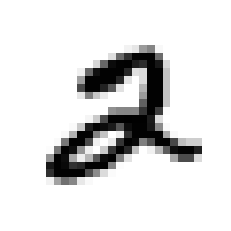

In [14]:
plot_digit(X_tc[5])

Já a função a seguir será usada para observar alguns plots ao mesmo tempo.

In [15]:
def plot_n_random_digits(x,labels=None,n_images=9,title='Digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data_raw.shape[1],data_raw.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(12,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        if labels != None:
            ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
        ax.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

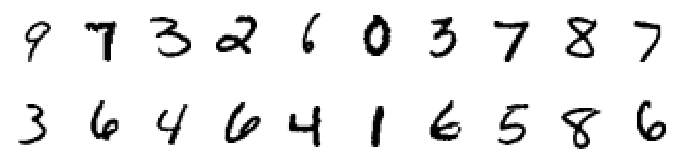

In [16]:
plot_n_random_digits(X_tc,n_images=20)

## Data loader

O Data loader é usado para fazer mini batches de treino. Vamos passar os dados e definir alguns parâmetros como o mini batch size o `Data.DataLoader` nos retornará um iterator.

In [49]:
# Mini batch size
mb_size = 64
# Preparando nossos tensores para o data loader
torch_dataset = Data.TensorDataset(X_tc,y_tc)
# Definindo o data loader
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = mb_size,
        shuffle=True,
        pin_memory=True,
        num_workers=12
        )

## Definindo as arquiteturas das redes neurais

Nesta seção vamos definir como serão o Gerador e o Discriminador com o pytorch. Se você não está acostumado com o pytorch, não se preocupe o método a seguir para criar uma rede neural é bem padrão do pytorch e você consegue encontrar vários exemplos na internet, inclusive na [documentação do pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).

### Gerador

O Gerador é uma rede neural comum e basicamente qualquer arquitetura pode ser utilizada, ele deve receber um tensor de ruído com dimensão `nz` e retornar um tensor com as mesmas dimensões do dados originais, `X_dim`. Vamos tentar usar uma arquitetura de autoencoder para este dataset.

In [131]:
# Dimensões
a_dim,b_dim,c_dim = [784,392,196]
X_dim = X_tc.shape[1]
nz = 100

<img src="images/generator_architecture.png"
     alt="images/generator_architecture"
     style="float: left; margin-right: 3px; width: 200;" />

In [132]:
# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(nz, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, b_dim)
        self.hidden3 = torch.nn.Linear(b_dim, c_dim)
        self.hidden4 = torch.nn.Linear(c_dim, b_dim)
        self.hidden5 = torch.nn.Linear(b_dim, a_dim)
        self.out = torch.nn.Linear(a_dim, X_dim)
    
    def forward(self,z):
        h = torch.relu(self.hidden1(z))
        h = torch.dropout(torch.relu(self.hidden2(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden3(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden4(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden5(h)),p=0.5,train=True)
        h = torch.tanh(self.out(h))
        return h

### Discriminador

No Discriminador vamos usar uma rede linear com quatro camadas internas. Ele precisa receber uma observação e retorna a probabilidade desta ser verdadeira.

<img src="images/discriminator_architecture.jpg"
     alt="images/discriminator_architecture"
     style="float: left; margin-right: 3px; width: 200;" />

In [133]:
# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(X_dim, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, a_dim)
        self.hidden3 = torch.nn.Linear(a_dim, a_dim)
        self.out = torch.nn.Linear(a_dim, 1)
    
    def forward(self,x):
        h = F.leaky_relu(self.hidden1(x))
        h = torch.dropout(F.leaky_relu(self.hidden2(h)),p=0.5,train=True)
        h = torch.dropout(F.leaky_relu(self.hidden3(h)),p=0.5,train=True)
        y = torch.sigmoid(self.out(h))
        return y

### Instanciamos as redes

Definidas as classes podemos instanciar o Gerador e o Discriminador. O único argumento que recebem é o número de GPUs disponíveis e ainda usamos o `.to(device)` para mandar as redes para o dispositivo disponível. As últimas linhas servem para paralelizar automaticamente o treino em diferentes GPUs.

In [134]:
G = GNet(ngpu).to(device)
D = DNet(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))

Se você tiver um modelo salvo pode carregá-lo usando a célula abaixo.

In [135]:
# #load models
# G.load_state_dict(torch.load('models/g_shapleygan_bigan.pt'))
# F.load_state_dict(torch.load('models/f_shapleygan_bigan.pt'))
# Dx.load_state_dict(torch.load('models/d_shapleygan_bigan.pt'))

### Inicialização de pesos e otimizadores

Para inicializar os pesos das redes usaremos a [Xavier normal](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_normal_).

In [136]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.01)  
    
#Inicializar pesos das redes
G.apply(init_weights)
D.apply(init_weights)

print(G)
print(D)

GNet(
  (hidden1): Linear(in_features=100, out_features=784, bias=True)
  (hidden2): Linear(in_features=784, out_features=392, bias=True)
  (hidden3): Linear(in_features=392, out_features=196, bias=True)
  (hidden4): Linear(in_features=196, out_features=392, bias=True)
  (hidden5): Linear(in_features=392, out_features=784, bias=True)
  (out): Linear(in_features=784, out_features=784, bias=True)
)
DNet(
  (hidden1): Linear(in_features=784, out_features=784, bias=True)
  (hidden2): Linear(in_features=784, out_features=784, bias=True)
  (hidden3): Linear(in_features=784, out_features=784, bias=True)
  (out): Linear(in_features=784, out_features=1, bias=True)
)


Nosso otimizador será o [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) e passaremos como argumento os pesos da redes, a taxa de aprendizado e o beta.

In [137]:
# Definimos os otimizadores
lrg,lrd = [1e-4,1e-3]
beta = 0.4
G_optim = optim.Adam(G.parameters(), lr=lrg, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lrd, betas=(beta,0.999))

A função abaixo é usada para reiniciar os gradientes. Se não os reiniciarmos o pytorch por padrão somará os gradientes com os de épocas anteriores cada vez que forem calculados. No caso de RNN está soma é utilizada.

In [138]:
def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

### Funções de perda

O cálculo das perdas da GAN pode ser feito utilizando a `binary cross entropy`. Por padrão os otimizadores tentam minimizar as perdas, ao contrário das equações abaixo. Entretanto, a `binary cross entropy` já é definida com um sinal negativo, então automaticamente a perda será minimizada.

<img src="images/gan_loss.gif"
     alt="images/gan_loss"
     style="float: left; margin-right: 3px; width: 50;" />

As variáveis `real_label` e `fake_label` serão usadas para calcular a perda quando um dado é real ou falso.

In [139]:
# função de perda
bce_loss = nn.BCELoss()

real_label = 1
fake_label = 0

Abaixo definimos uma função para plotar as perdas e também uma função que faz o sampling do ruído.

In [140]:
def plot_losses(losses_his):
    labels = ['Loss: G','Loss: D','Loss: D real','Loss: D fake']
    fig = plt.figure(figsize=(20, 10))
    for i, col in enumerate(labels):
        ax = fig.add_subplot(3, 2, i + 1)
        plt.ylabel(col,fontsize=15)
        plt.plot(losses_his[i])
        ax.grid(True)
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def noise(n_sample,nz):
    return torch.randn(n_sample, nz).to(device)

As listas abaixo serão usadas para armazenar o valor das perdas e o ruído fixo para acompanharmos a evolução do treino.

In [141]:
G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his, D_his, D_real_his, D_fake_his]

fixed_noise = noise(64,nz)
img_list = []

## Treinamento da GAN

O loop de treinamento é bem simples, vamos definir um número de épocas e depois iterar o loader para receber os mini batches. Os tensores `ones` e `zeros` definidos abaixo serão usados para informar se os dados são verdadeiros ou falsos. Os passos básicos são:
- Geramos dados falsos e pegamos dados verdadeiros do loader;
- Passamos cada um desses para o Discriminador;
- Calculamos o erro de cada um e usamos esses para atualizar o Discriminador;
- Geramos outros dados falsos;
- Calculamos o erro apenas destes e atualizamos o Gerador.

De tempos em tempos recolhemos alguns dados para acompanhar a evolução do treino e também printamos os erros.

In [142]:
def print_losses(G_loss, D_loss, D_loss_real, D_loss_fake):
        print("""D_loss: {:.5f} | G_loss: {:.5f}""".format(D_loss.data, G_loss.data))
        print("""D_real: {:.5f} | D_fake: {:.5f}""".format(D_loss_real.data, D_loss_real.data))

def append_losses(G_loss, D_loss, D_loss_real, D_loss_fake):
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)

def generate_samples(G,n_sample,nz):
    z = noise(n_sample,nz)
    g = G(z)
    return g

def nets_test(n_sample,G,D,X_tc):
    g = generate_samples(G,n_sample,nz)
    D_real = D(X_tc[:n_sample])
    D_fake = D(g)
    print('D_real  {:.3f} +- {:.3f}'.format(D_real.mean(),D_real.std()))
    print('D_fake  {:.3f} +- {:.3f}'.format(D_fake.mean(),D_fake.std()))

In [143]:
%%time
epochs = 30
iters=0

for epoch in range(1,epochs+1):
    # Amostragem de dados
    for i, data in enumerate(loader):
        X = data[0].to(device)
        X_size = X.shape[0]
        ones = torch.full((X_size,), real_label, device=device)
        zeros = torch.full((X_size,), fake_label, device=device)
        
        # D
        z = noise(X_size,nz)
        X_fake = G(z)    
        D_real = D(X)
        D_fake = D(X_fake)
        D_loss_real = bce_loss(D_real.view(-1), ones.view(-1))
        D_loss_fake = bce_loss(D_fake.view(-1), zeros.view(-1))
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optim.step()    
        reset_grad()

        # G
        for j in range(3):
            z = noise(X_size,nz)
            X_fake_ = G(z)
            D_fake = D(X_fake_)
            G_loss  = bce_loss(D_fake.view(-1), ones.view(-1))
            G_loss.backward(retain_graph=True)
            G_optim.step()
            reset_grad()


        append_losses(G_loss, D_loss, D_loss_real, D_loss_fake)
        
    if (iters % 2 == 0) or ((epoch == epochs-1) and (i == len(loader)-1)):
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake.reshape(64,1,28,28).to(device)[:64], padding=2, normalize=True))
    iters += 1
    
    if epoch % int(epochs/5) == 0 and epoch > 0:
        print('Epoch {}'.format(epoch))
        print_losses(G_loss, D_loss, D_loss_real, D_loss_fake)
        nets_test(20000,G,D,X)
        print('-'*40)

Epoch 6
D_loss: 1.19665 | G_loss: 1.07944
D_real: 0.55900 | D_fake: 0.55900
D_real  0.688 +- 0.163
D_fake  0.349 +- 0.167
----------------------------------------
Epoch 12
D_loss: 1.24979 | G_loss: 1.05537
D_real: 0.53096 | D_fake: 0.53096
D_real  0.568 +- 0.184
D_fake  0.395 +- 0.122
----------------------------------------
Epoch 18
D_loss: 1.22350 | G_loss: 0.66563
D_real: 0.63671 | D_fake: 0.63671
D_real  0.586 +- 0.144
D_fake  0.523 +- 0.121
----------------------------------------
Epoch 24
D_loss: 1.31077 | G_loss: 0.81909
D_real: 0.68563 | D_fake: 0.68563
D_real  0.571 +- 0.154
D_fake  0.440 +- 0.115
----------------------------------------
Epoch 30
D_loss: 1.27823 | G_loss: 0.79850
D_real: 0.68187 | D_fake: 0.68187
D_real  0.596 +- 0.191
D_fake  0.451 +- 0.130
----------------------------------------
CPU times: user 5min 32s, sys: 20.5 s, total: 5min 52s
Wall time: 5min 12s


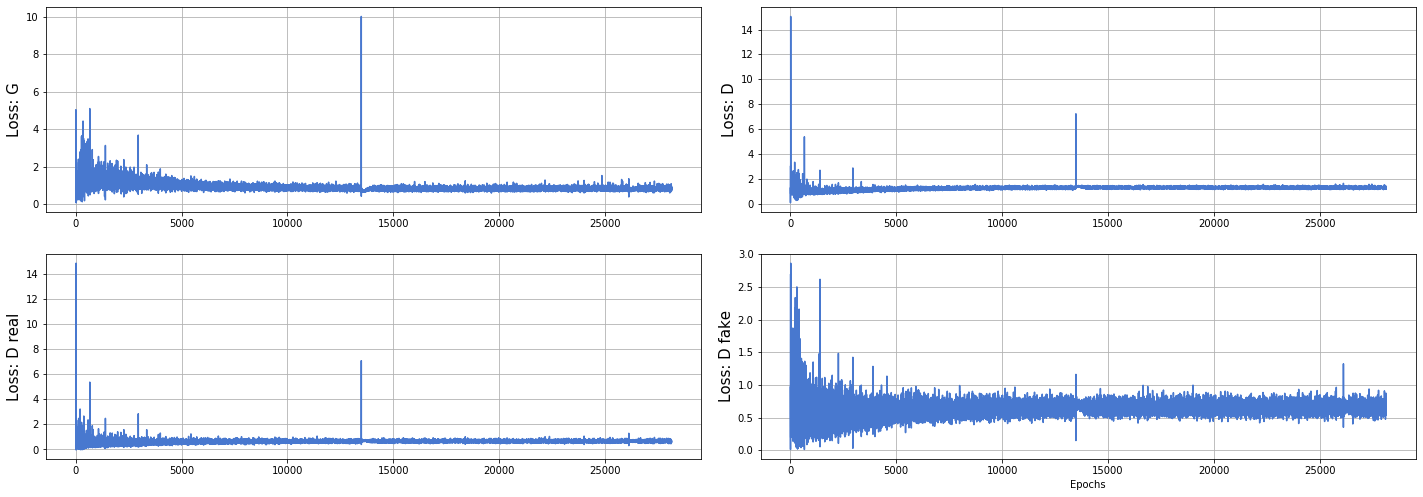

In [144]:
plot_losses(losses_his)

<Figure size 432x288 with 0 Axes>

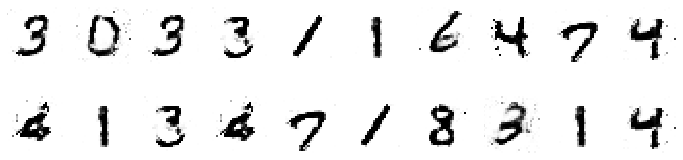

In [145]:
X_fake = generate_samples(G,20,nz)
plot_n_random_digits(X_fake.cpu(),labels=None,n_images=20,title='Digits')

<Figure size 432x288 with 0 Axes>

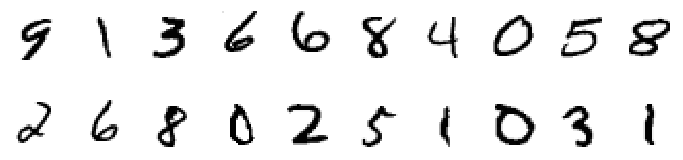

In [47]:
plot_n_random_digits(X_tc,n_images=20)

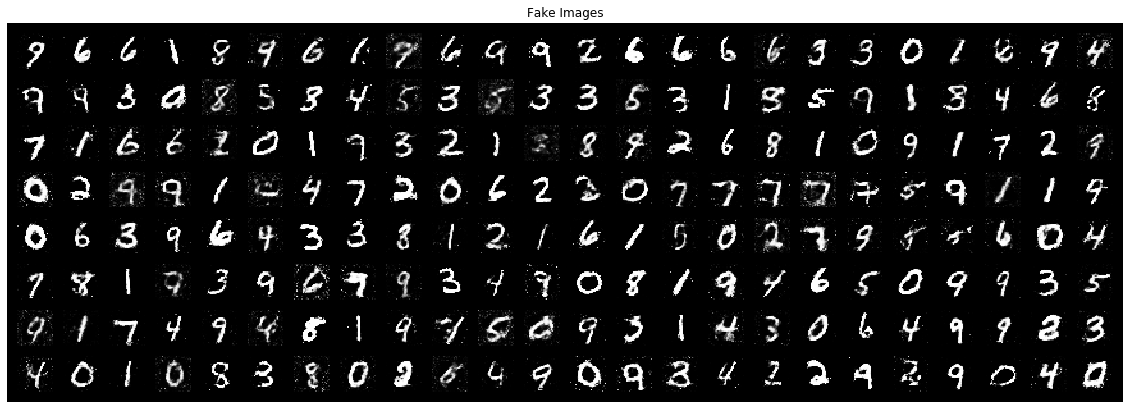

In [146]:
num_images = 64*3
X_fake = generate_samples(G,num_images,nz).detach().cpu()
plt.figure(figsize=(20,7))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(X_fake.reshape(num_images,1,28,28).to(device), padding=8, nrow=24, normalize=True).cpu(),(1,2,0)))
plt.show()

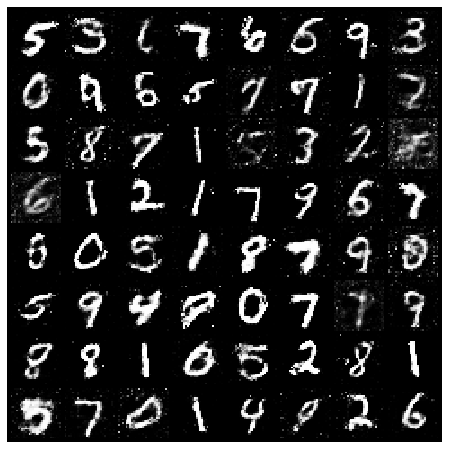

In [147]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [148]:
def compare_images():
    real_batch = next(iter(loader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].reshape(mb_size,1,28,28).to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
#         plt.imshow(np.transpose(vutils.make_grid(img_list[i].reshape(64,1,28,28).to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()

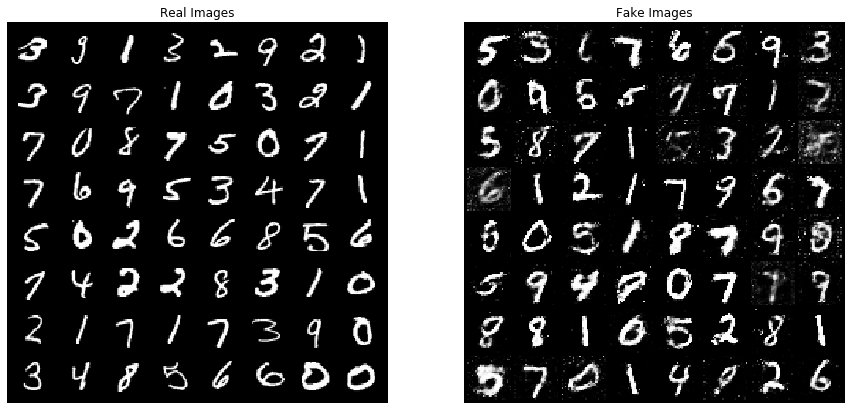

In [149]:
compare_images()